In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

# Data fetching
# Custom data fetcher to replace broken YahooDataProvider
# The qiskit-finance YahooDataProvider has compatibility issues with latest yfinance
import yfinance as yf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Extract data

In [4]:
# Portfolio parameters
# Data parameters
START_DATE = datetime.now() - timedelta(days=365*2)  # 2 years of data
END_DATE = datetime.now()

# S&P 500 stocks (diversified sector selection)
TICKERS = [
    # Technology
    'NVDA',  # NVIDIA
    'MSFT',  # Microsoft
    'AAPL',  # Apple
    'AMZN',  # Amazon
    'META',  # Meta
    'AVGO',  # Broadcom
    'GOOGL', # Alphabet
    'TSLA',  # Tesla
    'BRK-B', # Berkshire Hathaway
    'WMT',   # Walmart
]


print(f"Configuration:")
print(f"  Tickers: {TICKERS}")
print(f"  Date range: {START_DATE.date()} to {END_DATE.date()}")

Configuration:
  Tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'WMT']
  Date range: 2023-10-25 to 2025-10-24


In [ ]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch stock data and compute returns, covariance, and correlation.

    Args:
        tickers: List of ticker symbols
        start_date: Start date
        end_date: End date

    Returns:
        mean_returns, covariance_matrix, daily_returns, prices
    """
    print(f"Fetching data for {len(tickers)} stocks from Yahoo Finance...")

    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Extract adjusted close prices
    if len(tickers) == 1:
        prices = data['Adj Close'].to_frame()
        prices.columns = tickers
    else:
        prices = data['Adj Close']

    # Drop any NaN values
    prices = prices.dropna()

    print(f"Downloaded {len(prices)} days of price data")

    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Calculate mean returns (daily)
    mean_returns = returns.mean().values

    # Calculate sample covariance matrix (daily)
    sample_covariance_matrix = returns.cov().values

    return mean_returns, sample_covariance_matrix, returns, prices

mean_returns, covariance_matrix, daily_returns, price_data = fetch_stock_data(
    TICKERS, START_DATE, END_DATE
)

print(f"\nData fetched successfully!")
print(f"Mean returns shape: {mean_returns.shape}")
print(f"Covariance matrix shape: {covariance_matrix.shape}")
print(f"Daily returns shape: {daily_returns.shape}")

Fetching data for 10 stocks from Yahoo Finance...
Downloaded 501 days of price data

Data fetched successfully!
Mean returns shape: (10,)
Covariance matrix shape: (10, 10)
Daily returns shape: (500, 10)


In [9]:
for i, ticker in enumerate(TICKERS):
    print(f"  {ticker}: {mean_returns[i]*252:.2%}")  # Annualized (252 trading days)

  NVDA: 25.42%
  MSFT: 34.94%
  AAPL: 85.19%
  AMZN: 20.28%
  META: 39.99%
  AVGO: 51.98%
  GOOGL: 24.56%
  TSLA: 87.09%
  BRK-B: 57.44%
  WMT: 37.71%


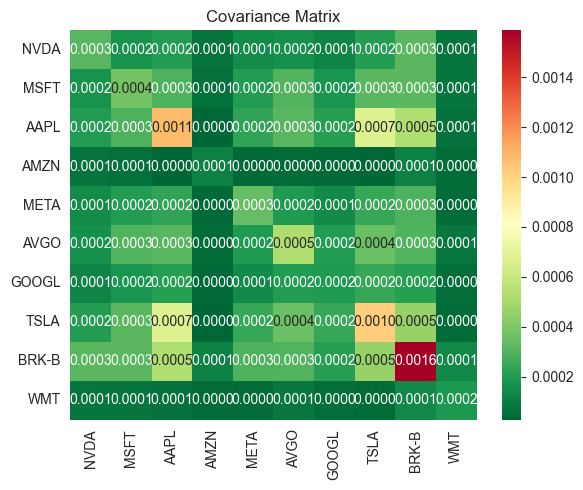

In [10]:
# Visualize covariance matrix - single plot version
plt.figure(figsize=(6, 5))

# Covariance matrix
sns.heatmap(covariance_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            xticklabels=TICKERS, yticklabels=TICKERS)
plt.title('Covariance Matrix')

plt.tight_layout()
plt.show()

In [11]:
covariance_matrix

array([[3.14093518e-04, 1.74055970e-04, 1.99654281e-04, 6.55905626e-05,
        1.49042269e-04, 1.64145916e-04, 1.25412896e-04, 2.07737421e-04,
        3.16911105e-04, 7.42893346e-05],
       [1.74055970e-04, 3.74850045e-04, 2.94506028e-04, 5.74115007e-05,
        1.99973465e-04, 2.96644397e-04, 1.77937115e-04, 3.18435689e-04,
        3.19314103e-04, 7.54357003e-05],
       [1.99654281e-04, 2.94506028e-04, 1.07842269e-03, 2.80172487e-05,
        2.29391801e-04, 3.14016090e-04, 2.13859459e-04, 6.73354952e-04,
        5.29781717e-04, 5.90022447e-05],
       [6.55905626e-05, 5.74115007e-05, 2.80172487e-05, 1.08924431e-04,
        3.53642656e-05, 4.58361716e-05, 3.79539476e-05, 3.28501760e-05,
        1.08336924e-04, 4.38749141e-05],
       [1.49042269e-04, 1.99973465e-04, 2.29391801e-04, 3.53642656e-05,
        3.44320239e-04, 1.94784928e-04, 1.40596304e-04, 2.42245795e-04,
        2.90222660e-04, 4.27237986e-05],
       [1.64145916e-04, 2.96644397e-04, 3.14016090e-04, 4.58361716e-05,
   

# Ledoit-Wolf Function

In [13]:
# Ledoit-Wolf Shrinkage
lw_estimator = LedoitWolf()
lw_estimator.fit(daily_returns)

shrunk_cov_matrix = lw_estimator.covariance_

print("Ledoit-Wolf Estimator")
print(f"Optimal shrinkage coefficient (delta*): {lw_estimator.shrinkage_:.6f}")
print(f"Shrunk covariance matrix shape: {shrunk_cov_matrix.shape}")

Ledoit-Wolf Estimator
Optimal shrinkage coefficient (delta*): 0.045175
Shrunk covariance matrix shape: (10, 10)


In [14]:
shrunk_cov_matrix

array([[3.25146002e-04, 1.65860625e-04, 1.90253652e-04, 6.25022616e-05,
        1.42024683e-04, 1.56417182e-04, 1.19507889e-04, 1.97956201e-04,
        3.01989493e-04, 7.07914560e-05],
       [1.65860625e-04, 3.83041837e-04, 2.80639349e-04, 5.47083070e-05,
        1.90557808e-04, 2.82677034e-04, 1.69559029e-04, 3.03442293e-04,
        3.04279347e-04, 7.18838456e-05],
       [1.90253652e-04, 2.80639349e-04, 1.05348710e-03, 2.66980696e-05,
        2.18590995e-04, 2.99230789e-04, 2.03789986e-04, 6.41650348e-04,
        5.04837192e-04, 5.62241515e-05],
       [6.25022616e-05, 5.47083070e-05, 2.66980696e-05, 1.29637206e-04,
        3.36991556e-05, 4.36779969e-05, 3.61669037e-05, 3.13034408e-05,
        1.03235930e-04, 4.18090843e-05],
       [1.42024683e-04, 1.90557808e-04, 2.18590995e-04, 3.36991556e-05,
        3.53949513e-04, 1.85613571e-04, 1.33976393e-04, 2.30839765e-04,
        2.76557662e-04, 4.07121685e-05],
       [1.56417182e-04, 2.82677034e-04, 2.99230789e-04, 4.36779969e-05,
   

# QUBO formulation

In [20]:
mu = np.asarray(mean_returns).reshape(-1)
Sigma = np.asarray(shrunk_cov_matrix)

B = 3
gamma = 1.0 # Example parameters

Q = - (gamma / (B**2)) * Sigma.copy()
c = (1.0 / B) * mu

Q = (Q + Q.T) / 2.0 # Ensure numerical symmetry

Q_upper = np.triu(Q)

print("QUBO matrix shape:", Q.shape)
print("linear term shape:", c.shape)

QUBO matrix shape: (10, 10)
linear term shape: (10,)
